* Author: Niclas Lavesson
* Date: 2026-01-14
* Description: This notebook (1) removes redundant variables, (2) run PCA on multicollinear variables and (3) determines what features that makes most sense to include in prediction model

* Since multicollinearity is removed, this data set can be used for linear prediction models (and not only to tree classifiers). There is however a chance that the PCA removes some information that could have predictive power.

# Feature engineering

## Loading the data from BQ

In [2]:
from google.cloud import bigquery as bq
import pandas as pd

bq_client = bq.Client()

def load_bq_table_to_dataframe(table_path: str):
    """
    Loads data from a specified BigQuery table into a pandas DataFrame.

    Args:
        table_path (str): The full path to the BigQuery table (e.g., 'project.dataset.table').

    Returns:
        pandas.DataFrame: A DataFrame containing the data from the BigQuery table.
    """
    query_string = f"SELECT * FROM `{table_path}`"
    print(f"Executing BigQuery query for table: {table_path}")
    bq_query_job = bq_client.query(query_string, job_config=bq.QueryJobConfig())
    return bq_query_job.to_dataframe()

# Define the table paths (as strings)
base_path = 'ingka-ff-somdata-prod.OMDA_Analytics'
train_table_path = f'{base_path}.no_stock_prediction_train_data_processed'
test_table_path = f'{base_path}.no_stock_prediction_test_data_processed'

# Load data frames
merged_train_data = load_bq_table_to_dataframe(train_table_path)
merged_test_data = load_bq_table_to_dataframe(test_table_path)

print("DataFrames loaded successfully!")

Executing BigQuery query for table: ingka-ff-somdata-prod.OMDA_Analytics.no_stock_prediction_train_data_processed
Executing BigQuery query for table: ingka-ff-somdata-prod.OMDA_Analytics.no_stock_prediction_test_data_processed
DataFrames loaded successfully!


## Train data set

### Correlation matrix (before running PCA on multicollinear variables)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

print(f"Shape of loaded DataFrame: {merged_train_data.shape}")
print(f"Columns: {merged_train_data.columns.tolist()}")

# Calculate correlation matrix (only numeric columns)
numeric_columns = merged_train_data.select_dtypes(include=[np.number]).columns
merged_train_data_numeric = merged_train_data[numeric_columns]

correlation_matrix = merged_train_data_numeric.corr()

# Export to Excel
output_path = 'C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/correlation_merged_train_data.xlsx'
correlation_matrix.to_excel(output_path, sheet_name='Correlation Matrix')

print(f"Correlation matrix created and saved to {output_path}!")
print(f"Shape of correlation matrix: {correlation_matrix.shape}")
print(f"Number of features correlated: {len(numeric_columns)}")
print("\nFirst 5 rows of the correlation matrix:")
print(correlation_matrix.head())


Shape of loaded DataFrame: (1416764, 167)
Columns: ['ordered_qty', 'line_total_euros', 'no_of_DS', 'no_of_PS', 'promised_update_DS', 'promised_update_PS', 'forecast_stock_current_day', 'forecast_volume_current_day', 'forecast_stock_previous_day', 'forecast_volume_previous_day', 'forecast_stock_next_day', 'forecast_volume_next_day', 'item_id_service_level', 'ddc_item', 'availability_qty', 'average_stock_4_weeks', 'stock_variance_4_weeks', 'current_daily_stock_change_rate', 'average_daily_stock_change_rate_replenishment', 'average_daily_stock_change_rate', 'stockout_count_28_days', 'days_since_last_stockout', 'replenishment_count_28_days', 'days_since_last_replenishment', 'estimated_days_till_next_stockout', 'ordered_qty_delivery', 'ordered_qty_order', 'ddc_ordered_qty', 'ddc_ordered_qty_delivery', 'ddc_ordered_qty_order', 'sl1_ordered_qty', 'sl2_ordered_qty', 'sl3_ordered_qty', 'sl4_ordered_qty', 'sl1_ordered_qty_delivery', 'sl2_ordered_qty_delivery', 'sl3_ordered_qty_delivery', 'sl4_or

#### Converting list of relevant variables to numeric fields
* All beforehand redundant variables are removed here (for e.g. variables expressed in different time units etc)

In [3]:
import pandas as pd
import numpy as np

# List of variables to convert to numeric (here I remove obviously redundant variables)
variables_to_test = [
    # Country variables (significant)
    'country_code_AU', 'country_code_BE', 'country_code_CA','country_code_CH','country_code_CN','country_code_DE',
    'country_code_DK','country_code_ES','country_code_FI','country_code_FR','country_code_GB','country_code_IE',
    'country_code_IN','country_code_IT','country_code_NL','country_code_NO','country_code_PL','country_code_SE',
    'country_code_US',
    
    # Customer type variables (significant)
    'customer_type_PRIVATE', 'customer_type_Unknown',
    
    # Item name variables (significant)
    'item_name_count',
    
    # Order Stage variables (significant)
    'order_stage_deviation_ORDER_PROCESSING',
    
    # Order Type variables (significant)
    'order_type_HOME_DELIVERY',
    
    # Payment Type variables (significant)
    'payment_type_open_invoice',
    'payment_type_payment_on_date',
    
    # Sales Channel variables - Significant
    'sales_channel_REMOTE_OTHER_RANGE','sales_channel_REMOTE_EMAIL_SALES','sales_channel_FAX','sales_channel_REMOTE_BEDROOM',
    'sales_channel_OUTBOUND_LEAD_SALES','sales_channel_STORE','sales_channel_REMOTE_INT_DESIGN','sales_channel_REMOTE_KITCHEN',
    'sales_channel_INTERNET',
    
    # Sales Channel variables - Insignificant
    'sales_channel_PROACTIVE_CHAT','sales_channel_PHONE','sales_channel_TELANSMACH','sales_channel_OUTBOUND_PHONE',
    'sales_channel_REMOTEKITCHENPLANNIN','sales_channel_REMOTE_LIVINGROOM','sales_channel_REMOTE_BATHROOM','sales_channel_SOCIAL_MEDIA',
    'sales_channel_LETTER','sales_channel_DIGITAL_MEETING',
    
    # Service Type variables - Significant
    'service_type_PUOP','service_type_HOME_DELIVERY','service_type_PUP',
    
    # Service Type variables - Insignificant
    'service_type_LOCKER',
    
    # CDC variables - Significant
    'ship_node_CDC_037','ship_node_CDC_269','ship_node_CDC_085','ship_node_CDC_074','ship_node_CDC_084','ship_node_CDC_077',
    'ship_node_CDC_063','ship_node_CDC_078','ship_node_CDC_057','ship_node_CDC_017','ship_node_CDC_031','ship_node_CDC_008',
    'ship_node_CDC_053','ship_node_CDC_043','ship_node_CDC_081','ship_node_CDC_004','ship_node_CDC_087','ship_node_CDC_024',
    'ship_node_CDC_051','ship_node_CDC_041','ship_node_CDC_020','ship_node_CDC_424','ship_node_CDC_079','ship_node_CDC_452',
    'ship_node_CDC_945','ship_node_CDC_034','ship_node_CDC_048','ship_node_CDC_086','ship_node_CDC_013','ship_node_CDC_050',
    'ship_node_CDC_005','ship_node_CDC_025','ship_node_CDC_016','ship_node_CDC_418','ship_node_CDC_054','ship_node_CDC_076',
    'ship_node_CDC_960','ship_node_CDC_405','ship_node_CDC_018','ship_node_CDC_012',
    
    # CDC variables - Insignificant
    'ship_node_CDC_064','ship_node_CDC_083','ship_node_CDC_023','ship_node_CDC_045','ship_node_CDC_080','ship_node_CDC_044',
    
    # Deviation Rate variables (significant)
    'ship_node_deviation_rate_1month','ship_node_stock_related_deviation_rate_1month',
    
    # Numerical features 
    'availability_qty',
    'average_daily_stock_change_rate',
    'average_daily_stock_change_rate_replenishment',
    'average_stock_4_weeks',
    'current_daily_stock_change_rate',
    'days_since_last_replenishment',
    'days_since_last_stockout',
    'estimated_days_till_next_stockout',
    'replenishment_count_28_days',
    'stock_variance_4_weeks',
    'stockout_count_28_days',
    'forecast_stock_current_day',
    'forecast_stock_next_day',
    'forecast_stock_previous_day',
    'forecast_volume_current_day',
    'forecast_volume_next_day',
    'forecast_volume_previous_day',
    'no_of_DS',
    'no_of_PS',
    'no_sl_item',
    'no_sl_ordered_qty_order',
    'ordered_qty',
    'ordered_qty_delivery',
    'ordered_qty_order',
    'promised_update_DS',
    'promised_update_PS',
    'line_total_euros',
    'sl1_item',
    'sl1_ordered_qty',
    'sl1_ordered_qty_delivery',
    'sl1_ordered_qty_order',
    'sl2_item',
    'sl2_ordered_qty',
    'sl2_ordered_qty_delivery',
    'sl2_ordered_qty_order',
    'sl3_item',
    'sl3_ordered_qty',
    'sl3_ordered_qty_delivery',
    'sl3_ordered_qty_order',
    'sl4_item',
    'sl4_ordered_qty',
    'sl4_ordered_qty_delivery',
    'sl4_ordered_qty_order',
    'time_in_status_mins',
    'time_to_dispatch_date_mins',
    'time_to_min_notification_date_mins',
    'time_to_promised_appt_start_date_mins',
    'time_to_WO_acknowledgement_date_mins',
    'time_to_wo_creation_date_mins'
]

# Convert all specified variables to numeric (float64)
for col in variables_to_test:
    if col in merged_train_data.columns:
        merged_train_data[col] = pd.to_numeric(merged_train_data[col], errors='coerce').astype(np.float64)

print(f"✅ Converted {len([col for col in variables_to_test if col in merged_train_data.columns])} variables to numeric (float64)")


✅ Converted 146 variables to numeric (float64)


### Multicollinearity test 1: (all relevant features)
* Logit regressions have been run on each variables to see which ones that are significant (this information is not used here but is indicated below)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

# List of variables to test for multicollinearity
variables_to_test = variables_to_test

print("\n" + "="*80)
print("--- STARTING MULTICOLLINEARITY TEST (VIF) ---")
print("="*80)
print(f"Total variables to test: {len(variables_to_test)}")

# 1. Select the relevant columns from merged_train_data
existing_variables = [var for var in variables_to_test if var in merged_train_data.columns]
if len(existing_variables) < len(variables_to_test):
    missing = set(variables_to_test) - set(existing_variables)
    print(f"\n⚠️  Warning: {len(missing)} variables not found in merged_train_data")
    if len(missing) <= 20:
        for var in sorted(missing):
            print(f"  - {var}")
    else:
        print(f"  (Too many to display - {len(missing)} missing variables)")

print(f"\n✓ Proceeding with {len(existing_variables)} existing variables")

X_vif = merged_train_data[existing_variables].copy()
print(f"Initial shape: {X_vif.shape}")

# 2. AGGRESSIVE DATA TYPE CLEANING
print("\n" + "="*80)
print("--- STEP 1: DATA TYPE VALIDATION & CONVERSION ---")
print("="*80)

# Check initial data types
dtype_summary = X_vif.dtypes.value_counts()
print("\nInitial data type distribution:")
for dtype, count in dtype_summary.items():
    print(f"  {dtype}: {count} columns")

# Identify and handle non-numeric columns
non_numeric_cols = X_vif.select_dtypes(exclude=[np.number]).columns.tolist()

if non_numeric_cols:
    print(f"\n⚠️  Found {len(non_numeric_cols)} non-numeric columns")
    print("\nAttempting conversion to numeric...")
    
    conversion_report = []
    
    for col in non_numeric_cols:
        original_dtype = X_vif[col].dtype
        unique_count = X_vif[col].nunique()
        sample_values = X_vif[col].dropna().head(5).tolist()
        
        # Try to convert
        original_non_null = X_vif[col].notna().sum()
        X_vif[col] = pd.to_numeric(X_vif[col], errors='coerce')
        new_non_null = X_vif[col].notna().sum()
        
        lost_values = original_non_null - new_non_null
        conversion_report.append({
            'Column': col,
            'Original_Type': original_dtype,
            'Unique_Values': unique_count,
            'Values_Lost': lost_values,
            'Sample': str(sample_values[:3])
        })
    
    # Display conversion report
    conv_df = pd.DataFrame(conversion_report)
    print("\nConversion Report:")
    print(conv_df.to_string(index=False))
    
    # Remove columns that lost too much data
    problematic_cols = conv_df[conv_df['Values_Lost'] > 0]['Column'].tolist()
    if problematic_cols:
        print(f"\n⚠️  WARNING: {len(problematic_cols)} columns lost data during conversion:")
        for col in problematic_cols:
            lost = conv_df[conv_df['Column'] == col]['Values_Lost'].values[0]
            print(f"  - {col}: {lost} values lost")

# Force all columns to numeric (this catches edge cases)
print("\n🔧 Forcing all columns to numeric type...")
for col in X_vif.columns:
    if X_vif[col].dtype == 'object' or X_vif[col].dtype.name == 'category':
        X_vif[col] = pd.to_numeric(X_vif[col], errors='coerce')

# Verify all columns are now numeric
final_non_numeric = X_vif.select_dtypes(exclude=[np.number]).columns.tolist()
if final_non_numeric:
    print(f"\n❌ ERROR: Still have {len(final_non_numeric)} non-numeric columns after conversion:")
    for col in final_non_numeric:
        print(f"  - {col}: {X_vif[col].dtype}")
    print("\nRemoving these columns from analysis...")
    X_vif = X_vif.drop(columns=final_non_numeric)
else:
    print("✓ All columns are now numeric")

# 3. HANDLE INFINITE VALUES
print("\n" + "="*80)
print("--- STEP 2: CHECKING FOR INFINITE VALUES ---")
print("="*80)

inf_report = []
for col in X_vif.columns:
    inf_count = np.isinf(X_vif[col]).sum()
    if inf_count > 0:
        inf_report.append({'Column': col, 'Infinite_Count': inf_count})
        X_vif[col] = X_vif[col].replace([np.inf, -np.inf], np.nan)

if inf_report:
    inf_df = pd.DataFrame(inf_report)
    print(f"\n⚠️  Found infinite values in {len(inf_report)} columns:")
    print(inf_df.to_string(index=False))
    print("✓ Replaced infinite values with NaN")
else:
    print("✓ No infinite values found")

# 4. HANDLE MISSING VALUES
print("\n" + "="*80)
print("--- STEP 3: HANDLING MISSING VALUES ---")
print("="*80)

initial_rows = X_vif.shape[0]
missing_per_col = X_vif.isnull().sum()
cols_with_missing = missing_per_col[missing_per_col > 0].sort_values(ascending=False)

if len(cols_with_missing) > 0:
    print(f"\nFound missing values in {len(cols_with_missing)} columns")
    print("\nTop 15 columns with missing values:")
    print(cols_with_missing.head(15).to_frame('Missing_Count'))
    print(f"\nTotal missing values: {X_vif.isnull().sum().sum():,}")
    print(f"Missing value percentage: {(X_vif.isnull().sum().sum() / (X_vif.shape[0] * X_vif.shape[1]) * 100):.2f}%")
else:
    print("✓ No missing values found")

print("\n🔧 Dropping rows with any missing values...")
X_vif = X_vif.dropna()
rows_dropped = initial_rows - X_vif.shape[0]

print(f"✓ Dropped {rows_dropped:,} rows ({rows_dropped/initial_rows*100:.2f}%)")
print(f"✓ Remaining rows: {X_vif.shape[0]:,}")

if X_vif.empty:
    print("\n❌ ERROR: DataFrame is empty after cleaning!")
    print("\nPossible reasons:")
    print("  1. Too many missing values in the data")
    print("  2. Data type conversion created too many NaN values")
    print("  3. Variables not properly encoded in source data")
    print("\nRecommendation: Check your data preprocessing pipeline")
    raise ValueError("Cannot proceed with VIF calculation - no data remaining")

# 5. CHECK FOR ZERO VARIANCE
print("\n" + "="*80)
print("--- STEP 4: CHECKING FOR ZERO VARIANCE COLUMNS ---")
print("="*80)

zero_var_cols = []
for col in X_vif.columns:
    if X_vif[col].std() == 0 or X_vif[col].nunique() == 1:
        unique_val = X_vif[col].iloc[0]
        zero_var_cols.append({'Column': col, 'Constant_Value': unique_val})

if zero_var_cols:
    zv_df = pd.DataFrame(zero_var_cols)
    print(f"\n⚠️  Found {len(zero_var_cols)} zero-variance columns:")
    print(zv_df.to_string(index=False))
    
    cols_to_remove = [item['Column'] for item in zero_var_cols]
    X_vif = X_vif.drop(columns=cols_to_remove)
    print(f"\n✓ Removed {len(cols_to_remove)} zero-variance columns")
else:
    print("✓ No zero-variance columns found")

# 6. FINAL VALIDATION BEFORE VIF
print("\n" + "="*80)
print("--- STEP 5: FINAL DATA VALIDATION ---")
print("="*80)

print(f"Final shape: {X_vif.shape}")

# CRITICAL FIX: Convert ALL columns to float64 to ensure numeric type
print("\n🔧 Converting all columns to float64...")
for col in X_vif.columns:
    try:
        X_vif[col] = X_vif[col].astype(np.float64)
    except Exception as e:
        print(f"  ⚠️  Error converting {col} to float64: {str(e)}")
        print(f"      Data type: {X_vif[col].dtype}")
        print(f"      Sample values: {X_vif[col].head(3).tolist()}")

# Verify all columns are now numeric
all_numeric = X_vif.select_dtypes(include=[np.number]).shape[1] == X_vif.shape[1]
print(f"All numeric: {all_numeric}")

if not all_numeric:
    non_num = X_vif.select_dtypes(exclude=[np.number]).columns.tolist()
    print(f"❌ Still have non-numeric columns: {non_num}")
    print("Removing these columns...")
    X_vif = X_vif.select_dtypes(include=[np.number])
    print(f"✓ Kept only numeric columns. New shape: {X_vif.shape}")

print(f"No missing values: {X_vif.isnull().sum().sum() == 0}")

# Now safe to check for infinite values
try:
    inf_check = np.isinf(X_vif.values).sum()
    print(f"No infinite values: {inf_check == 0}")
    if inf_check > 0:
        print(f"  ⚠️  Found {inf_check} infinite values, replacing with NaN...")
        X_vif = X_vif.replace([np.inf, -np.inf], np.nan)
        X_vif = X_vif.dropna()
        print(f"  ✓ Cleaned. New shape: {X_vif.shape}")
except Exception as e:
    print(f"⚠️  Could not check for infinite values: {str(e)}")
    print("Attempting to clean by selecting only finite values...")
    # Alternative approach: keep only rows where all values are finite
    mask = np.isfinite(X_vif.select_dtypes(include=[np.number]).values).all(axis=1)
    X_vif = X_vif[mask]
    print(f"✓ Cleaned. New shape: {X_vif.shape}")

# Additional check: ensure values are actually finite
print("\nChecking if all values are finite...")
problematic_cols = []
for col in X_vif.columns:
    try:
        if not np.isfinite(X_vif[col].values).all():
            problematic_cols.append(col)
            print(f"  ⚠️  {col}: Contains non-finite values")
    except Exception as e:
        print(f"  ⚠️  {col}: Error checking finite values - {str(e)}")
        problematic_cols.append(col)

if problematic_cols:
    print(f"\n❌ Found {len(problematic_cols)} columns with non-finite values")
    print("Removing these columns...")
    X_vif = X_vif.drop(columns=problematic_cols)
    print(f"✓ Removed {len(problematic_cols)} problematic columns")
    print(f"✓ Remaining shape: {X_vif.shape}")
else:
    print("✓ All values are finite")

# Ensure we still have data
if X_vif.shape[1] == 0:
    raise ValueError("❌ No columns remaining after data validation!")
if X_vif.shape[0] == 0:
    raise ValueError("❌ No rows remaining after data validation!")

print(f"\n✅ Data validation complete!")
print(f"   Ready for VIF calculation with {X_vif.shape[1]} variables and {X_vif.shape[0]:,} observations")

# 7. CALCULATE VIF
print("\n" + "="*80)
print("--- STEP 6: CALCULATING VIF ---")
print("="*80)

try:
    # Add constant
    print("\nAdding constant term...")
    X_vif_const = add_constant(X_vif, has_constant='add')
    print(f"✓ Constant added. New shape: {X_vif_const.shape}")
    
    # Verify the constant column is numeric and finite
    if 'const' in X_vif_const.columns:
        const_check = np.isfinite(X_vif_const['const'].values).all()
        if not const_check:
            print("⚠️  Constant column has non-finite values, fixing...")
            X_vif_const['const'] = 1.0
    
    # Final check before VIF calculation
    print("\nFinal pre-VIF validation...")
    print(f"  Shape: {X_vif_const.shape}")
    print(f"  Data type: {X_vif_const.values.dtype}")
    print(f"  All finite: {np.isfinite(X_vif_const.values).all()}")
    
    # Calculate VIF with progress indicator
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif_const.columns
    
    vif_values = []
    total_vars = X_vif_const.shape[1]
    print(f"\nCalculating VIF for {total_vars} variables (including constant)...")
    print("This may take a while for large datasets...\n")
    
    for i in range(total_vars):
        if i % 10 == 0 or i == total_vars - 1:
            print(f"  Progress: {i+1}/{total_vars} ({(i+1)/total_vars*100:.1f}%)")
        
        try:
            vif = variance_inflation_factor(X_vif_const.values, i)
            vif_values.append(vif)
        except Exception as e:
            print(f"  ⚠️  Error calculating VIF for variable {X_vif_const.columns[i]}: {str(e)}")
            vif_values.append(np.nan)
    
    vif_data["VIF"] = vif_values
    
    # Remove the constant row
    vif_data = vif_data[vif_data['Variable'] != 'const']
    
    # Remove any rows with NaN VIF values
    nan_vif_count = vif_data['VIF'].isna().sum()
    if nan_vif_count > 0:
        print(f"\n⚠️  Warning: {nan_vif_count} variables had VIF calculation errors and will be excluded")
        nan_vars = vif_data[vif_data['VIF'].isna()]['Variable'].tolist()
        print(f"Variables with errors: {nan_vars}")
        vif_data = vif_data.dropna(subset=['VIF'])
    
    # Sort by VIF (descending)
    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
    
    print(f"\n✅ VIF calculation complete for {len(vif_data)} variables!")
    
    # 8. DISPLAY RESULTS
    print("\n" + "="*80)
    print("--- VIF RESULTS ---")
    print("="*80)
    print(vif_data.to_string())
    
    # Summary statistics
    print("\n" + "="*80)
    print("--- VIF SUMMARY STATISTICS ---")
    print("="*80)
    print(f"Total variables analyzed: {len(vif_data)}")
    print(f"Mean VIF: {vif_data['VIF'].mean():.2f}")
    print(f"Median VIF: {vif_data['VIF'].median():.2f}")
    print(f"Max VIF: {vif_data['VIF'].max():.2f} ({vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']})")
    print(f"Min VIF: {vif_data['VIF'].min():.2f} ({vif_data.loc[vif_data['VIF'].idxmin(), 'Variable']})")
    
    # Flag high VIF variables
    high_vif_5 = vif_data[vif_data['VIF'] >= 5].copy()
    high_vif_10 = vif_data[vif_data['VIF'] >= 10].copy()
    high_vif_20 = vif_data[vif_data['VIF'] >= 20].copy()
    
    print(f"\nVariables with VIF >= 5: {len(high_vif_5)} ({len(high_vif_5)/len(vif_data)*100:.1f}%)")
    print(f"Variables with VIF >= 10: {len(high_vif_10)} ({len(high_vif_10)/len(vif_data)*100:.1f}%)")
    print(f"Variables with VIF >= 20: {len(high_vif_20)} ({len(high_vif_20)/len(vif_data)*100:.1f}%)")
    
    if len(high_vif_20) > 0:
        print("\n" + "="*80)
        print("⚠️  SEVERE MULTICOLLINEARITY DETECTED (VIF >= 20)")
        print("="*80)
        print(high_vif_20[['Variable', 'VIF']].to_string(index=False))
        print("\n⚠️  These variables are HIGHLY correlated with other predictors!")
        print("   Strong recommendation to address before modeling.")
    
    elif len(high_vif_10) > 0:
        print("\n" + "="*80)
        print("⚠️  HIGH MULTICOLLINEARITY DETECTED (VIF >= 10)")
        print("="*80)
        print(high_vif_10[['Variable', 'VIF']].head(20).to_string(index=False))
        if len(high_vif_10) > 20:
            print(f"   ... and {len(high_vif_10) - 20} more variables")
        print("\n⚠️  Consider addressing these variables before modeling.")
    
    # Interpretation Guidance
    print("\n" + "="*80)
    print("--- INTERPRETATION GUIDANCE ---")
    print("="*80)
    print("VIF (Variance Inflation Factor) indicates multicollinearity severity:")
    print("  • VIF = 1: No correlation with other predictors")
    print("  • 1 < VIF < 5: Moderate correlation (generally acceptable)")
    print("  • 5 ≤ VIF < 10: High correlation (investigate)")
    print("  • VIF ≥ 10: Very high correlation (action recommended)")
    print("  • VIF ≥ 20: Severe correlation (action strongly recommended)")
    print("\nRecommended actions for high VIF:")
    print("  1. Remove one of the highly correlated variables")
    print("  2. Combine correlated variables (e.g., create indices or composite scores)")
    print("  3. Use dimensionality reduction (PCA, factor analysis)")
    print("  4. Use regularization techniques (Ridge, Lasso, Elastic Net)")
    print("  5. Check for perfect multicollinearity (e.g., dummy variable trap)")
    
    # 9. SAVE RESULTS TO EXCEL
    # 9. SAVE RESULTS TO EXCEL
    print("\n" + "="*80)
    print("--- SAVING RESULTS ---")
    print("="*80)
    
    output_vif_filename = 'vif_results_summary.xlsx'
    output_vif_path = f'C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/{output_vif_filename}'
    
    try:
        with pd.ExcelWriter(output_vif_path, engine='openpyxl') as writer:
            # Sheet 1: Main VIF results
            vif_data.to_excel(writer, sheet_name='VIF_Results', index=False)
            
            # Sheet 2: High VIF variables (>= 10)
            if len(high_vif_10) > 0:
                high_vif_10.to_excel(writer, sheet_name='High_VIF_10', index=False)
            
            # Sheet 3: Moderate-High VIF variables (>= 5)
            if len(high_vif_5) > 0:
                high_vif_5.to_excel(writer, sheet_name='High_VIF_5', index=False)
            
            # Sheet 4: Very High VIF variables (>= 20)
            if len(high_vif_20) > 0:
                high_vif_20.to_excel(writer, sheet_name='Severe_VIF_20', index=False)
            
            # Sheet 5: Summary statistics
            summary_stats = pd.DataFrame({
                'Metric': [
                    'Total Variables Tested',
                    'Variables in Final Analysis', 
                    'Mean VIF', 
                    'Median VIF', 
                    'Max VIF',
                    'Min VIF',
                    'Variables with VIF >= 5',
                    'Variables with VIF >= 10',
                    'Variables with VIF >= 20',
                    'Observations Used',
                    'Original Observations',
                    'Rows Dropped',
                    'Drop Rate (%)',
                    'Original Variables',
                    'Missing Variables',
                    'Zero Variance Columns Removed',
                    'Non-numeric Columns Encountered'
                ],
                'Value': [
                    len(variables_to_test),
                    len(vif_data),
                    round(vif_data['VIF'].mean(), 2),
                    round(vif_data['VIF'].median(), 2),
                    round(vif_data['VIF'].max(), 2),
                    round(vif_data['VIF'].min(), 2),
                    len(high_vif_5),
                    len(high_vif_10),
                    len(high_vif_20),
                    X_vif.shape[0],
                    initial_rows,
                    rows_dropped,
                    round(rows_dropped/initial_rows*100, 2),
                    len(variables_to_test),
                    len(variables_to_test) - len(existing_variables),
                    len(zero_var_cols) if zero_var_cols else 0,
                    len(non_numeric_cols) if non_numeric_cols else 0
                ]
            })
            summary_stats.to_excel(writer, sheet_name='Summary', index=False)
            
            # Sheet 6: Data quality issues (if any)
            quality_issues = []
            
            # Non-numeric columns
            if non_numeric_cols:
                for col in non_numeric_cols:
                    quality_issues.append({
                        'Issue_Type': 'Non-Numeric Column',
                        'Variable': col,
                        'Details': 'Required conversion to numeric'
                    })
            
            # Infinite values
            if inf_report:
                for item in inf_report:
                    quality_issues.append({
                        'Issue_Type': 'Infinite Values',
                        'Variable': item['Column'],
                        'Details': f"{item['Infinite_Count']} infinite values"
                    })
            
            # Zero variance
            if zero_var_cols:
                for item in zero_var_cols:
                    quality_issues.append({
                        'Issue_Type': 'Zero Variance',
                        'Variable': item['Column'],
                        'Details': f"Constant value: {item['Constant_Value']}"
                    })
            
            # Missing values (top issues)
            if len(cols_with_missing) > 0:
                for col in cols_with_missing.head(20).index:
                    quality_issues.append({
                        'Issue_Type': 'Missing Values',
                        'Variable': col,
                        'Details': f"{cols_with_missing[col]} missing values"
                    })
            
            # Problematic columns removed during validation
            if problematic_cols:
                for col in problematic_cols:
                    quality_issues.append({
                        'Issue_Type': 'Non-Finite Values',
                        'Variable': col,
                        'Details': 'Removed due to non-finite values'
                    })
            
            if quality_issues:
                quality_df = pd.DataFrame(quality_issues)
                quality_df.to_excel(writer, sheet_name='Data_Quality_Issues', index=False)
            
            # Sheet 7: Interpretation guide
            interpretation_guide = pd.DataFrame({
                'VIF Range': ['VIF = 1', '1 < VIF < 5', '5 ≤ VIF < 10', 'VIF ≥ 10', 'VIF ≥ 20'],
                'Interpretation': [
                    'No multicollinearity',
                    'Moderate multicollinearity (acceptable)',
                    'High multicollinearity (investigate)',
                    'Very high multicollinearity (action recommended)',
                    'Severe multicollinearity (action strongly recommended)'
                ],
                'Recommended Action': [
                    'None needed',
                    'Monitor but generally OK',
                    'Consider removing or combining variables',
                    'Remove, combine, or use regularization',
                    'Must address before modeling'
                ]
            })
            interpretation_guide.to_excel(writer, sheet_name='Interpretation_Guide', index=False)
        
        print(f"✅ VIF results successfully saved to: {output_vif_filename}")
        print(f"   File location: C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/{output_vif_filename}")
        print("\n📊 Excel file contains the following sheets:")
        print("   1. VIF_Results - Complete VIF values for all variables")
        if len(high_vif_10) > 0:
            print("   2. High_VIF_10 - Variables with VIF >= 10")
        if len(high_vif_5) > 0:
            print("   3. High_VIF_5 - Variables with VIF >= 5")
        if len(high_vif_20) > 0:
            print("   4. Severe_VIF_20 - Variables with VIF >= 20")
        print("   5. Summary - Summary statistics and overview")
        if quality_issues:
            print("   6. Data_Quality_Issues - Data quality problems encountered")
        print("   7. Interpretation_Guide - How to interpret VIF values")
        
    except Exception as e:
        print(f"❌ Error saving Excel file: {str(e)}")
        print("Attempting to save as CSV instead...")
        csv_path = 'C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/vif_results.csv'
        vif_data.to_csv(csv_path, index=False)
        print(f"✅ Results saved as CSV: {csv_path}")

except Exception as e:
    print(f"\n❌ ERROR during VIF calculation: {str(e)}")
    print("\n" + "="*80)
    print("DETAILED ERROR INFORMATION")
    print("="*80)
    import traceback
    traceback.print_exc()
    
    print("\n" + "="*80)
    print("TROUBLESHOOTING STEPS")
    print("="*80)
    print("1. Check the data type diagnostics above")
    print("2. Verify all columns are numeric (no objects, strings, or categories)")
    print("3. Look for perfect multicollinearity (correlation = 1.0)")
    print("4. Ensure sufficient variation in all variables")
    print("5. Check if any variables are linear combinations of others")
    print("6. Consider reducing the number of variables")
    print("\nIf the error persists, try:")
    print("  - Running VIF on a subset of variables first")
    print("  - Checking correlation matrix for perfect correlations")
    print("  - Verifying data preprocessing steps")
    print("\nAdditional debugging:")
    print(f"  - X_vif shape before error: {X_vif.shape if 'X_vif' in locals() else 'Not defined'}")
    print(f"  - Data types: {X_vif.dtypes.value_counts().to_dict() if 'X_vif' in locals() else 'Not defined'}")

print("\n" + "="*80)
print("--- MULTICOLLINEARITY TEST (VIF) COMPLETE ---")
print("="*80)




### PCA - Reducing dimensionality (all correlated features)
* Below are all variables showing VIF-values>10 (these are linear combinations of each other) - a PCA are run on these. The components of these are again later run against the non multicollinear variables to see that the multicollinearity problem has been solved properly.

In [4]:
multicollinear_variables_train = [
'country_code_AU',
'country_code_BE',
'country_code_CA',
'country_code_CH',
'country_code_CN',
'country_code_DE',
'country_code_DK',
'country_code_ES',
'country_code_FI',
'country_code_FR',
'country_code_GB',
'country_code_IE',
'country_code_IN',
'country_code_IT',
'country_code_NL',
'country_code_NO',
'country_code_PL',
'country_code_SE',
'country_code_US',
'order_type_HOME_DELIVERY',
'ship_node_CDC_037',
'service_type_HOME_DELIVERY',
'ship_node_CDC_013',
'ship_node_CDC_086',
'ship_node_CDC_048',
'ship_node_CDC_050',
'ship_node_CDC_034',
'ship_node_CDC_945',
'ship_node_CDC_079',
'ship_node_CDC_452',
'ship_node_CDC_424',
'ship_node_CDC_020',
'ship_node_CDC_041',
'ship_node_CDC_051',
'ship_node_CDC_087',
'ship_node_CDC_004',
'ship_node_CDC_081',
'ship_node_CDC_043',
'ship_node_CDC_053',
'ship_node_CDC_008',
'ship_node_CDC_031',
'ship_node_CDC_017',
'ship_node_CDC_057',
'ship_node_CDC_078',
'ship_node_CDC_063',
'ship_node_CDC_077',
'ship_node_CDC_084',
'ship_node_CDC_074',
'ship_node_CDC_085',
'ship_node_CDC_269',
'ship_node_CDC_025',
'ship_node_CDC_005',
'ship_node_CDC_016',
'ship_node_CDC_044',
'ship_node_CDC_080',
'ship_node_CDC_045',
'ship_node_CDC_023',
'ship_node_CDC_083',
'sl3_ordered_qty_order',
'sl4_item',
'sl4_ordered_qty_order',
'sl1_item',
'sl1_ordered_qty_order',
'sl2_item',
'sl3_item',
'sl2_ordered_qty_order',
'no_sl_ordered_qty_order',
'no_sl_item',
'ordered_qty_order',
'ship_node_CDC_405',
'ship_node_CDC_960',
'ship_node_CDC_076',
'ship_node_CDC_054',
'ship_node_CDC_418',
'ship_node_CDC_064',
'ship_node_CDC_012',
'ship_node_CDC_018',
'forecast_volume_current_day',
'forecast_volume_previous_day',
'ordered_qty_delivery',
'forecast_volume_next_day',
'sl2_ordered_qty_delivery',
'sl3_ordered_qty_delivery',
'sl1_ordered_qty_delivery',
'sl4_ordered_qty_delivery',
'sales_channel_INTERNET',
'sales_channel_STORE',
'ship_node_deviation_rate_1month',
'time_to_WO_acknowledgement_date_mins',
'time_to_wo_creation_date_mins',
'forecast_stock_current_day',
'availability_qty',
'sales_channel_PHONE',
'forecast_stock_previous_day',
'average_stock_4_weeks',
'ordered_qty',
'service_type_PUP',
'forecast_stock_next_day',
'sales_channel_REMOTE_KITCHEN',
'estimated_days_till_next_stockout'
]

* In this code pca_variables are used from the previous multicollinearity analysis. However, due to several hours of run time, pca_variables is replaced with multicollinear_variables_train (a list based on the previous analysis)


STARTING PCA ANALYSIS

Original data shape: (1416764, 100)
After removing missing values: (1416764, 100)
Rows dropped: 0 (0.00%)

🔧 Fitting PCA model (variables already standardized)...
✓ PCA model fitted

📊 Creating visualization...


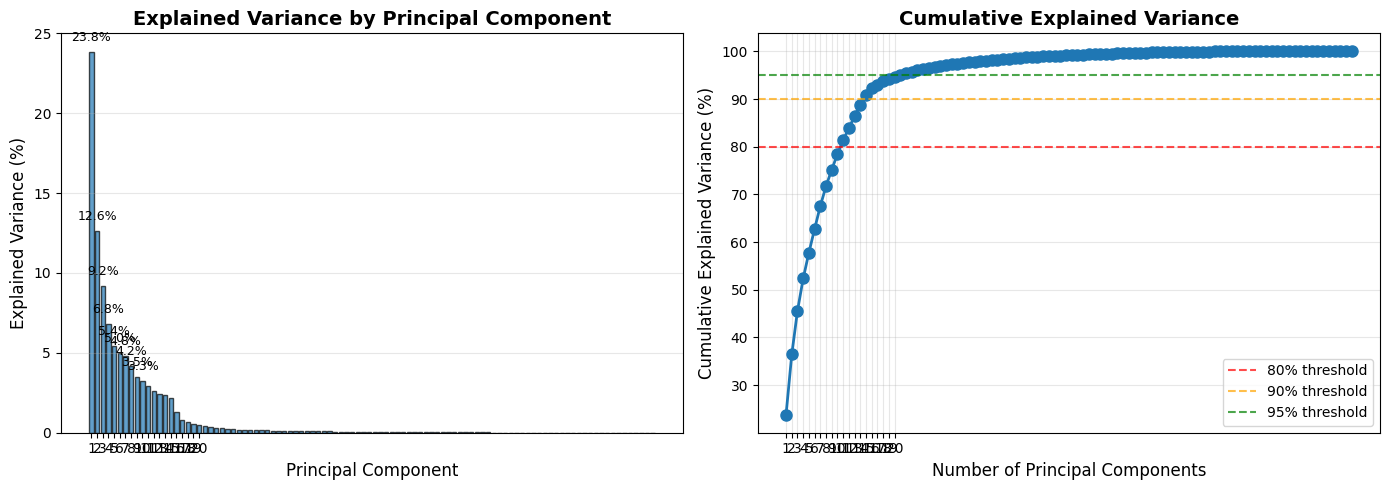

✓ Visualization saved to C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/pca_variance_analysis.png

PCA SUMMARY

Total number of original variables: 100
Total number of components: 100

Explained variance ratio per component (top 15):
  PC1: 23.81%
  PC2: 12.62%
  PC3: 9.16%
  PC4: 6.80%
  PC5: 5.43%
  PC6: 4.96%
  PC7: 4.82%
  PC8: 4.16%
  PC9: 3.47%
  PC10: 3.26%
  PC11: 2.90%
  PC12: 2.59%
  PC13: 2.45%
  PC14: 2.35%
  PC15: 2.19%
  ... and 85 more components

Cumulative explained variance (key thresholds):
  50% variance: 4 components (PC1-PC4)
  60% variance: 6 components (PC1-PC6)
  70% variance: 8 components (PC1-PC8)
  80% variance: 11 components (PC1-PC11)
  85% variance: 13 components (PC1-PC13)
  90% variance: 15 components (PC1-PC15)
  95% variance: 21 components (PC1-PC21)
  99% variance: 47 components (PC1-PC47)

RECOMMENDED NUMBER OF COMPONENTS
Components needed for 80% variance: 11 (reduces from 100 to 11)
Compo

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract variables with VIF > 10 from the VIF results
# multicollinear_variables_train = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()

# print("="*80)
# print("MULTICOLLINEAR VARIABLES (VIF > 10)")
# print("="*80)
# print(f"Total variables with VIF > 10: {len(multicollinear_variables_train)}\n")
# print("Variables:")
# for i, var in enumerate(multicollinear_variables_train, 1):
#     vif_value = vif_data[vif_data['Variable'] == var]['VIF'].values[0]
#     print(f"  {i}. {var}: VIF = {vif_value:.2f}")

# Use these variables for PCA
pca_variables = multicollinear_variables_train

print(f"\n{'='*80}")
print("STARTING PCA ANALYSIS")
print("="*80)

# Extract the relevant columns
X_pca = merged_train_data[pca_variables].copy()

# Handle missing values
initial_shape = X_pca.shape
X_pca_clean = X_pca.dropna()
rows_dropped = initial_shape[0] - X_pca_clean.shape[0]

print(f"\nOriginal data shape: {initial_shape}")
print(f"After removing missing values: {X_pca_clean.shape}")
print(f"Rows dropped: {rows_dropped} ({rows_dropped/initial_shape[0]*100:.2f}%)")

if X_pca_clean.empty:
    raise ValueError("No data remaining after dropping missing values!")

# Fit PCA model (no standardization - variables already standardized)
print("\n🔧 Fitting PCA model (variables already standardized)...")
pca = PCA()
X_pca_transformed = pca.fit_transform(X_pca_clean)
print("✓ PCA model fitted")

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create the plots
print("\n📊 Creating visualization...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Explained variance per component
ax1.bar(range(1, len(explained_variance_ratio) + 1), 
        explained_variance_ratio * 100,
        alpha=0.7,
        edgecolor='black')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance (%)', fontsize=12)
ax1.set_title('Explained Variance by Principal Component', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, min(len(explained_variance_ratio) + 1, 21)))  # Limit to 20 for readability
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels on bars (only for first 10 components for readability)
for i, v in enumerate(explained_variance_ratio[:10] * 100):
    ax1.text(i + 1, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), 
         cumulative_variance_ratio * 100,
         marker='o',
         linewidth=2,
         markersize=8)
ax2.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
ax2.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax2.axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% threshold')
ax2.set_xlabel('Number of Principal Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance (%)', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
ax2.set_xticks(range(1, min(len(cumulative_variance_ratio) + 1, 21)))
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/pca_variance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Visualization saved to C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/pca_variance_analysis.png")

# Print summary statistics
print("\n" + "="*80)
print("PCA SUMMARY")
print("="*80)
print(f"\nTotal number of original variables: {len(pca_variables)}")
print(f"Total number of components: {pca.n_components_}")

print(f"\nExplained variance ratio per component (top 15):")
for i, var in enumerate(explained_variance_ratio[:15]):
    print(f"  PC{i+1}: {var*100:.2f}%")
if len(explained_variance_ratio) > 15:
    print(f"  ... and {len(explained_variance_ratio) - 15} more components")

print(f"\nCumulative explained variance (key thresholds):")
milestones = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
for milestone in milestones:
    if cumulative_variance_ratio[-1] >= milestone:
        n_comp = np.argmax(cumulative_variance_ratio >= milestone) + 1
        print(f"  {milestone*100:.0f}% variance: {n_comp} components (PC1-PC{n_comp})")

# Find number of components needed for 80%, 90%, and 95% variance
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.80) + 1 if cumulative_variance_ratio[-1] >= 0.80 else len(cumulative_variance_ratio)
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1 if cumulative_variance_ratio[-1] >= 0.90 else len(cumulative_variance_ratio)
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1 if cumulative_variance_ratio[-1] >= 0.95 else len(cumulative_variance_ratio)

print(f"\n" + "="*80)
print("RECOMMENDED NUMBER OF COMPONENTS")
print("="*80)
print(f"Components needed for 80% variance: {n_components_80} (reduces from {len(pca_variables)} to {n_components_80})")
print(f"Components needed for 90% variance: {n_components_90} (reduces from {len(pca_variables)} to {n_components_90})")
print(f"Components needed for 95% variance: {n_components_95} (reduces from {len(pca_variables)} to {n_components_95})")

dimensionality_reduction_80 = ((len(pca_variables) - n_components_80) / len(pca_variables)) * 100
dimensionality_reduction_90 = ((len(pca_variables) - n_components_90) / len(pca_variables)) * 100
dimensionality_reduction_95 = ((len(pca_variables) - n_components_95) / len(pca_variables)) * 100

print(f"\nDimensionality reduction:")
print(f"  80% variance: {dimensionality_reduction_80:.1f}% reduction")
print(f"  90% variance: {dimensionality_reduction_90:.1f}% reduction")
print(f"  95% variance: {dimensionality_reduction_95:.1f}% reduction")

print("\n✓ PCA analysis complete!")

# Create a DataFrame from the transformed PCA components
# Use the index from X_pca_clean to ensure correct alignment with the original data
print("\n" + "="*80)
print("ADDING PCA COMPONENTS TO DATASET")
print("="*80)

pca_df = pd.DataFrame(data=X_pca_transformed,
                      columns=[f'multicollinearity_PC{i+1}' for i in range(X_pca_transformed.shape[1])],
                      index=X_pca_clean.index)

# Merge the PCA components back into the original merged_train_data
initial_cols = merged_train_data.shape[1]
merged_train_data = merged_train_data.merge(pca_df, left_index=True, right_index=True, how='left')
new_cols = merged_train_data.shape[1]

print(f"\nShape of merged_train_data before adding PCA: {(merged_train_data.shape[0], initial_cols)}")
print(f"Shape of merged_train_data after adding PCA: {merged_train_data.shape}")
print(f"New columns added: {new_cols - initial_cols}")
print(f"\nPCA component columns: {pca_df.columns.tolist()}")

print("\nFirst 5 rows of PCA components:")
# print(merged_train_data[pca_df.columns].head())

print("\nMissing values in PCA components:")
missing_pca = merged_train_data[pca_df.columns].isnull().sum()
if missing_pca.sum() > 0:
    print(missing_pca[missing_pca > 0])
    print(f"\nTotal rows with missing PCA values: {merged_train_data[pca_df.columns].isnull().any(axis=1).sum()}")
else:
    print("  ✓ No missing values in PCA components")

print("\n" + "="*80)
print("✅ PRINCIPAL COMPONENTS SUCCESSFULLY ADDED TO merged_train_data!")
print("="*80)

# Save summary to file
pca_summary = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained_Variance_Ratio': explained_variance_ratio,
    'Cumulative_Variance_Ratio': cumulative_variance_ratio
})

pca_summary.to_excel('C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/pca_summary.xlsx', index=False)
print("\n📊 PCA summary saved to C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/pca_summary.xlsx")


### Multicollinearity test 2: (all non multicollinear variables + PCA components)
* All non multicollinear variables are listed below, next the second multicollinearity test is run where uncorrelated variables (no MC) are run together with the PCA components from the correlated (MC variables). As a next step, components that are MC are removed (otherwise the problem with multicollinearity would persist)

In [ ]:
non_multicollinear_variables = [
'sl3_ordered_qty',
'ship_node_stock_related_deviation_rate_1month',
'sl2_ordered_qty',
'service_type_LOCKER',
'sl4_ordered_qty',
'payment_type_payment_on_date',
'service_type_PUOP',
'sl1_ordered_qty',
'ship_node_CDC_024',
'time_to_promised_appt_start_date_mins',
'time_to_min_notification_date_mins',
'average_daily_stock_change_rate_replenishment',
'sales_channel_REMOTE_EMAIL_SALES',
'average_daily_stock_change_rate',
'replenishment_count_28_days',
'sales_channel_TELANSMACH',
'payment_type_open_invoice',
'stock_variance_4_weeks',
'line_total_euros',
'days_since_last_stockout',
'sales_channel_REMOTE_BEDROOM',
'sales_channel_REMOTE_OTHER_RANGE',
'no_of_PS',
'sales_channel_LETTER',
'sales_channel_REMOTE_INT_DESIGN',
'sales_channel_FAX',
'no_of_DS',
'current_daily_stock_change_rate',
'sales_channel_DIGITAL_MEETING',
'time_in_status_mins',
'item_name_count',
'sales_channel_OUTBOUND_PHONE',
'promised_update_DS',
'promised_update_PS',
'sales_channel_OUTBOUND_LEAD_SALES',
'customer_type_PRIVATE',
'sales_channel_PROACTIVE_CHAT',
'stockout_count_28_days',
'days_since_last_replenishment',
'customer_type_Unknown',
'sales_channel_REMOTE_LIVINGROOM',
'order_stage_deviation_ORDER_PROCESSING',
'time_to_dispatch_date_mins',
'sales_channel_REMOTE_BATHROOM',
'sales_channel_SOCIAL_MEDIA',
'sales_channel_REMOTEKITCHENPLANNIN'
]

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

print("\n" + "="*80)
print("MULTICOLLINEARITY TEST AFTER PCA TRANSFORMATION")
print("="*80)

# Step 1: Identify variables with VIF <= 10 (non-multicollinear variables)
# non_multicollinear_variables = vif_data[vif_data['VIF'] <= 10]['Variable'].tolist()

print(f"\nVariables with VIF <= 10: {len(non_multicollinear_variables)}")
print(f"Variables with VIF > 10 (replaced by PCA): {len(multicollinear_variables_train)}")

# Step 2: Get all PCA component columns
pca_columns = [col for col in merged_train_data.columns if col.startswith('multicollinearity_PC')]
print(f"PCA components available: {len(pca_columns)}")

# Step 3: Combine non-multicollinear variables with PCA components
variables_for_vif_test = non_multicollinear_variables + pca_columns

print(f"\nTotal variables for new VIF test: {len(variables_for_vif_test)}")
print(f"  - Original variables (VIF <= 10): {len(non_multicollinear_variables)}")
print(f"  - PCA components: {len(pca_columns)}")

print("\n" + "="*80)
print("STARTING VIF CALCULATION ON TRANSFORMED DATASET")
print("="*80)

# Step 4: Extract the relevant columns
X_vif_pca = merged_train_data[variables_for_vif_test].copy()
print(f"\nInitial shape: {X_vif_pca.shape}")

# Step 5: Data cleaning and validation
print("\n--- DATA CLEANING ---")

# Convert all to float64
print("🔧 Converting all columns to float64...")
for col in X_vif_pca.columns:
    try:
        X_vif_pca[col] = X_vif_pca[col].astype(np.float64)
    except Exception as e:
        print(f"  ⚠️  Error converting {col}: {str(e)}")

# Check for non-numeric columns
non_numeric_cols = X_vif_pca.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print(f"⚠️  Found {len(non_numeric_cols)} non-numeric columns, removing...")
    X_vif_pca = X_vif_pca.select_dtypes(include=[np.number])
    print(f"✓ Removed. New shape: {X_vif_pca.shape}")
else:
    print("✓ All columns are numeric")

# Handle infinite values
print("\n🔧 Checking for infinite values...")
inf_count = 0
for col in X_vif_pca.columns:
    col_inf = np.isinf(X_vif_pca[col]).sum()
    if col_inf > 0:
        inf_count += col_inf
        X_vif_pca[col] = X_vif_pca[col].replace([np.inf, -np.inf], np.nan)

if inf_count > 0:
    print(f"✓ Replaced {inf_count} infinite values with NaN")
else:
    print("✓ No infinite values found")

# Handle missing values
print("\n🔧 Handling missing values...")
initial_rows = X_vif_pca.shape[0]
missing_count = X_vif_pca.isnull().sum().sum()
print(f"Total missing values: {missing_count:,}")

X_vif_pca = X_vif_pca.dropna()
rows_dropped = initial_rows - X_vif_pca.shape[0]
print(f"✓ Dropped {rows_dropped:,} rows ({rows_dropped/initial_rows*100:.2f}%)")
print(f"✓ Remaining rows: {X_vif_pca.shape[0]:,}")

if X_vif_pca.empty:
    raise ValueError("❌ No data remaining after cleaning!")

# Check for zero variance
print("\n🔧 Checking for zero variance columns...")
zero_var_cols = []
for col in X_vif_pca.columns:
    if X_vif_pca[col].std() == 0 or X_vif_pca[col].nunique() == 1:
        zero_var_cols.append(col)

if zero_var_cols:
    print(f"⚠️  Found {len(zero_var_cols)} zero-variance columns:")
    for col in zero_var_cols:
        print(f"  - {col}")
    X_vif_pca = X_vif_pca.drop(columns=zero_var_cols)
    print(f"✓ Removed. New shape: {X_vif_pca.shape}")
else:
    print("✓ No zero-variance columns found")

# Final validation
print("\n--- FINAL VALIDATION ---")
print(f"Final shape: {X_vif_pca.shape}")
print(f"All numeric: {X_vif_pca.select_dtypes(include=[np.number]).shape[1] == X_vif_pca.shape[1]}")
print(f"No missing values: {X_vif_pca.isnull().sum().sum() == 0}")
print(f"No infinite values: {np.isinf(X_vif_pca.values).sum() == 0}")

# Check all values are finite
problematic_cols = []
for col in X_vif_pca.columns:
    if not np.isfinite(X_vif_pca[col].values).all():
        problematic_cols.append(col)

if problematic_cols:
    print(f"⚠️  Found {len(problematic_cols)} columns with non-finite values, removing...")
    X_vif_pca = X_vif_pca.drop(columns=problematic_cols)
    print(f"✓ Removed. New shape: {X_vif_pca.shape}")
else:
    print("✓ All values are finite")

print(f"\n✅ Data ready for VIF calculation!")
print(f"   Variables: {X_vif_pca.shape[1]}")
print(f"   Observations: {X_vif_pca.shape[0]:,}")

# Step 6: Calculate VIF
print("\n" + "="*80)
print("CALCULATING VIF")
print("="*80)

try:
    # Add constant
    print("\n🔧 Adding constant term...")
    X_vif_pca_const = add_constant(X_vif_pca, has_constant='add')
    print(f"✓ Constant added. Shape: {X_vif_pca_const.shape}")
    
    # Verify constant is valid
    if 'const' in X_vif_pca_const.columns:
        if not np.isfinite(X_vif_pca_const['const'].values).all():
            X_vif_pca_const['const'] = 1.0
    
    # Calculate VIF
    vif_data_pca = pd.DataFrame()
    vif_data_pca["Variable"] = X_vif_pca_const.columns
    
    vif_values = []
    total_vars = X_vif_pca_const.shape[1]
    print(f"\nCalculating VIF for {total_vars} variables...")
    
    for i in range(total_vars):
        if i % 10 == 0 or i == total_vars - 1:
            print(f"  Progress: {i+1}/{total_vars} ({(i+1)/total_vars*100:.1f}%)")
        
        try:
            vif = variance_inflation_factor(X_vif_pca_const.values, i)
            vif_values.append(vif)
        except Exception as e:
            print(f"  ⚠️  Error for {X_vif_pca_const.columns[i]}: {str(e)}")
            vif_values.append(np.nan)
    
    vif_data_pca["VIF"] = vif_values
    
    # Remove constant row
    vif_data_pca = vif_data_pca[vif_data_pca['Variable'] != 'const']
    
    # Remove NaN VIF values
    nan_count = vif_data_pca['VIF'].isna().sum()
    if nan_count > 0:
        print(f"\n⚠️  {nan_count} variables had VIF calculation errors, excluding them")
        vif_data_pca = vif_data_pca.dropna(subset=['VIF'])
    
    # Sort by VIF
    vif_data_pca = vif_data_pca.sort_values(by="VIF", ascending=False).reset_index(drop=True)
    
    print(f"\n✅ VIF calculation complete for {len(vif_data_pca)} variables!")
    
    # Step 7: Display results
    print("\n" + "="*80)
    print("VIF RESULTS AFTER PCA TRANSFORMATION")
    print("="*80)
    print(vif_data_pca.to_string())
    
    # Summary statistics
    print("\n" + "="*80)
    print("VIF SUMMARY STATISTICS")
    print("="*80)
    print(f"Total variables analyzed: {len(vif_data_pca)}")
    print(f"Mean VIF: {vif_data_pca['VIF'].mean():.2f}")
    print(f"Median VIF: {vif_data_pca['VIF'].median():.2f}")
    print(f"Max VIF: {vif_data_pca['VIF'].max():.2f} ({vif_data_pca.loc[vif_data_pca['VIF'].idxmax(), 'Variable']})")
    print(f"Min VIF: {vif_data_pca['VIF'].min():.2f} ({vif_data_pca.loc[vif_data_pca['VIF'].idxmin(), 'Variable']})")
    
    # Flag high VIF variables
    high_vif_5_pca = vif_data_pca[vif_data_pca['VIF'] >= 5].copy()
    high_vif_10_pca = vif_data_pca[vif_data_pca['VIF'] >= 10].copy()
    high_vif_20_pca = vif_data_pca[vif_data_pca['VIF'] >= 20].copy()
    
    print(f"\nVariables with VIF >= 5: {len(high_vif_5_pca)} ({len(high_vif_5_pca)/len(vif_data_pca)*100:.1f}%)")
    print(f"Variables with VIF >= 10: {len(high_vif_10_pca)} ({len(high_vif_10_pca)/len(vif_data_pca)*100:.1f}%)")
    print(f"Variables with VIF >= 20: {len(high_vif_20_pca)} ({len(high_vif_20_pca)/len(vif_data_pca)*100:.1f}%)")
    
    # Comparison with original VIF
    print("\n" + "="*80)
    print("COMPARISON: BEFORE vs AFTER PCA")
    print("="*80)
    print(f"Original dataset:")
    # print(f"  Total variables: {len(vif_data)}")
    # print(f"  Mean VIF: {vif_data['VIF'].mean():.2f}")
    # print(f"  Variables with VIF > 10: {len(vif_data[vif_data['VIF'] > 10])}")
    print(f"\nAfter PCA transformation:")
    print(f"  Total variables: {len(vif_data_pca)}")
    print(f"  Mean VIF: {vif_data_pca['VIF'].mean():.2f}")
    print(f"  Variables with VIF > 10: {len(high_vif_10_pca)}")
    print(f"\nImprovement:")
    print(f"  Mean VIF reduction: {vif_data['VIF'].mean() - vif_data_pca['VIF'].mean():.2f}")
    print(f"  Variables with VIF > 10 reduced by: {len(vif_data[vif_data['VIF'] > 10]) - len(high_vif_10_pca)}")
    
    if len(high_vif_20_pca) > 0:
        print("\n" + "="*80)
        print("⚠️  SEVERE MULTICOLLINEARITY STILL DETECTED (VIF >= 20)")
        print("="*80)
        print(high_vif_20_pca[['Variable', 'VIF']].to_string(index=False))
        print("\n⚠️  Consider additional PCA or removing these variables")
    elif len(high_vif_10_pca) > 0:
        print("\n" + "="*80)
        print("⚠️  HIGH MULTICOLLINEARITY STILL DETECTED (VIF >= 10)")
        print("="*80)
        print(high_vif_10_pca[['Variable', 'VIF']].to_string(index=False))
        print("\n⚠️  Consider addressing these variables")
    else:
        print("\n" + "="*80)
        print("✅ SUCCESS: NO HIGH MULTICOLLINEARITY DETECTED!")
        print("="*80)
        print("All variables have VIF < 10. The PCA transformation successfully")
        print("resolved the multicollinearity issues!")
    
    # Separate PCA components from original variables
    pca_component_vif = vif_data_pca[vif_data_pca['Variable'].str.startswith('multicollinearity_PC')].copy()
    original_var_vif = vif_data_pca[~vif_data_pca['Variable'].str.startswith('multicollinearity_PC')].copy()
    
    print("\n" + "="*80)
    print("VIF BY VARIABLE TYPE")
    print("="*80)
    print(f"\nPCA Components ({len(pca_component_vif)} components):")
    print(f"  Mean VIF: {pca_component_vif['VIF'].mean():.2f}")
    print(f"  Max VIF: {pca_component_vif['VIF'].max():.2f}")
    print(f"  Components with VIF > 10: {len(pca_component_vif[pca_component_vif['VIF'] > 10])}")
    
    print(f"\nOriginal Variables ({len(original_var_vif)} variables):")
    print(f"  Mean VIF: {original_var_vif['VIF'].mean():.2f}")
    print(f"  Max VIF: {original_var_vif['VIF'].max():.2f}")
    print(f"  Variables with VIF > 10: {len(original_var_vif[original_var_vif['VIF'] > 10])}")

    # Step 8: Save results
    print("\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)
    
    output_filename = 'vif_results_after_pca.xlsx'
    output_path = f'C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/{output_filename}'
    
    try:
        with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
            # Sheet 1: All VIF results after PCA
            vif_data_pca.to_excel(writer, sheet_name='VIF_After_PCA', index=False)
            
            # Sheet 2: PCA components VIF
            if len(pca_component_vif) > 0:
                pca_component_vif.to_excel(writer, sheet_name='PCA_Components_VIF', index=False)
            
            # Sheet 3: Original variables VIF (VIF <= 10 from first test)
            if len(original_var_vif) > 0:
                original_var_vif.to_excel(writer, sheet_name='Original_Variables_VIF', index=False)
            
            # Sheet 4: High VIF variables (>= 10) after PCA
            if len(high_vif_10_pca) > 0:
                high_vif_10_pca.to_excel(writer, sheet_name='High_VIF_10_After_PCA', index=False)
            
            # Sheet 5: High VIF variables (>= 5) after PCA
            if len(high_vif_5_pca) > 0:
                high_vif_5_pca.to_excel(writer, sheet_name='High_VIF_5_After_PCA', index=False)
            
            # Sheet 6: Very high VIF variables (>= 20) after PCA
            if len(high_vif_20_pca) > 0:
                high_vif_20_pca.to_excel(writer, sheet_name='Severe_VIF_20_After_PCA', index=False)
            
            # Sheet 7: Comparison summary
            comparison_summary = pd.DataFrame({
                'Metric': [
                    'Total Variables - Before PCA',
                    'Total Variables - After PCA',
                    'Variables Removed (VIF > 10)',
                    'PCA Components Added',
                    'Mean VIF - Before PCA',
                    'Mean VIF - After PCA',
                    'Mean VIF Reduction',
                    'Median VIF - Before PCA',
                    'Median VIF - After PCA',
                    'Max VIF - Before PCA',
                    'Max VIF - After PCA',
                    'Variables with VIF >= 5 - Before',
                    'Variables with VIF >= 5 - After',
                    'Variables with VIF >= 10 - Before',
                    'Variables with VIF >= 10 - After',
                    'Variables with VIF >= 20 - Before',
                    'Variables with VIF >= 20 - After',
                    'Observations Used',
                    'Rows Dropped'
                ],
                'Value': [
                    len(vif_data),
                    len(vif_data_pca),
                    len(multicollinear_variables_train),
                    len(pca_columns),
                    round(vif_data['VIF'].mean(), 2),
                    round(vif_data_pca['VIF'].mean(), 2),
                    round(vif_data['VIF'].mean() - vif_data_pca['VIF'].mean(), 2),
                    round(vif_data['VIF'].median(), 2),
                    round(vif_data_pca['VIF'].median(), 2),
                    round(vif_data['VIF'].max(), 2),
                    round(vif_data_pca['VIF'].max(), 2),
                    len(vif_data[vif_data['VIF'] >= 5]),
                    len(high_vif_5_pca),
                    len(vif_data[vif_data['VIF'] > 10]),
                    len(high_vif_10_pca),
                    len(vif_data[vif_data['VIF'] >= 20]),
                    len(high_vif_20_pca),
                    X_vif_pca.shape[0],
                    rows_dropped
                ]
            })
            comparison_summary.to_excel(writer, sheet_name='Comparison_Summary', index=False)
            
            # Sheet 8: Variables removed and replaced
            variables_replaced = pd.DataFrame({
                'Removed_Variable': multicollinear_variables_train,
                'Original_VIF': [vif_data[vif_data['Variable'] == var]['VIF'].values[0] 
                                for var in multicollinear_variables_train],
                'Replaced_By': 'PCA Components (multicollinearity_PC1 to multicollinearity_PC' + str(len(pca_columns)) + ')'
            })
            variables_replaced = variables_replaced.sort_values('Original_VIF', ascending=False).reset_index(drop=True)
            variables_replaced.to_excel(writer, sheet_name='Variables_Replaced', index=False)
            
            # Sheet 9: Variable categories breakdown
            variable_categories = pd.DataFrame({
                'Category': [
                    'Non-multicollinear variables (VIF <= 10)',
                    'PCA components',
                    'Total variables in final dataset'
                ],
                'Count': [
                    len(non_multicollinear_variables),
                    len(pca_columns),
                    len(variables_for_vif_test)
                ],
                'Mean_VIF': [
                    round(original_var_vif['VIF'].mean(), 2) if len(original_var_vif) > 0 else 0,
                    round(pca_component_vif['VIF'].mean(), 2) if len(pca_component_vif) > 0 else 0,
                    round(vif_data_pca['VIF'].mean(), 2)
                ],
                'Max_VIF': [
                    round(original_var_vif['VIF'].max(), 2) if len(original_var_vif) > 0 else 0,
                    round(pca_component_vif['VIF'].max(), 2) if len(pca_component_vif) > 0 else 0,
                    round(vif_data_pca['VIF'].max(), 2)
                ]
            })
            variable_categories.to_excel(writer, sheet_name='Variable_Categories', index=False)
            
            # Sheet 10: Interpretation guide
            interpretation_guide = pd.DataFrame({
                'VIF Range': ['VIF = 1', '1 < VIF < 5', '5 ≤ VIF < 10', 'VIF ≥ 10', 'VIF ≥ 20'],
                'Interpretation': [
                    'No multicollinearity',
                    'Moderate multicollinearity (acceptable)',
                    'High multicollinearity (investigate)',
                    'Very high multicollinearity (action recommended)',
                    'Severe multicollinearity (action strongly recommended)'
                ],
                'Recommended Action': [
                    'None needed',
                    'Monitor but generally OK',
                    'Consider removing or combining variables',
                    'Remove, combine, or use regularization',
                    'Must address before modeling'
                ]
            })
            interpretation_guide.to_excel(writer, sheet_name='Interpretation_Guide', index=False)
        
        print(f"✅ Results successfully saved to: {output_filename}")
        print(f"   File location: /mnt/data/{output_filename}")
        print("\n📊 Excel file contains the following sheets:")
        print("   1. VIF_After_PCA - Complete VIF values after PCA transformation")
        if len(pca_component_vif) > 0:
            print("   2. PCA_Components_VIF - VIF values for PCA components only")
        if len(original_var_vif) > 0:
            print("   3. Original_Variables_VIF - VIF values for retained original variables")
        if len(high_vif_10_pca) > 0:
            print("   4. High_VIF_10_After_PCA - Variables with VIF >= 10 after PCA")
        if len(high_vif_5_pca) > 0:
            print("   5. High_VIF_5_After_PCA - Variables with VIF >= 5 after PCA")
        if len(high_vif_20_pca) > 0:
            print("   6. Severe_VIF_20_After_PCA - Variables with VIF >= 20 after PCA")
        print("   7. Comparison_Summary - Before vs After PCA comparison")
        print("   8. Variables_Replaced - List of variables replaced by PCA")
        print("   9. Variable_Categories - Breakdown by variable type")
        print("   10. Interpretation_Guide - How to interpret VIF values")
        
    except Exception as e:
        print(f"❌ Error saving Excel file: {str(e)}")
        print("Attempting to save as CSV instead...")
        csv_path = 'C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/vif_results_after_pca.csv'
        vif_data_pca.to_csv(csv_path, index=False)
        print(f"✅ Results saved as CSV: {csv_path}")

except Exception as e:
    print(f"\n❌ ERROR during VIF calculation: {str(e)}")
    print("\n" + "="*80)
    print("DETAILED ERROR INFORMATION")
    print("="*80)
    import traceback
    traceback.print_exc()
    
    print("\n" + "="*80)
    print("TROUBLESHOOTING STEPS")
    print("="*80)
    print("1. Check that PCA was successfully completed")
    print("2. Verify that multicollinearity_PC columns exist in merged_train_data")
    print("3. Check for perfect multicollinearity in remaining variables")
    print("4. Ensure sufficient variation in all variables")
    print("\nDebug information:")
    if 'X_vif_pca' in locals():
        print(f"  - X_vif_pca shape: {X_vif_pca.shape}")
        print(f"  - Data types: {X_vif_pca.dtypes.value_counts().to_dict()}")
    if 'variables_for_vif_test' in locals():
        print(f"  - Variables for test: {len(variables_for_vif_test)}")
    if 'pca_columns' in locals():
        print(f"  - PCA columns found: {len(pca_columns)}")

print("\n" + "="*80)
print("✅ MULTICOLLINEARITY TEST AFTER PCA COMPLETE")
print("="*80)

# Create a summary of the final variable set
print("\n" + "="*80)
print("FINAL VARIABLE SET SUMMARY")
print("="*80)
print(f"\nVariables to use in modeling:")
print(f"  Total: {len(variables_for_vif_test)}")
print(f"  - Non-multicollinear original variables: {len(non_multicollinear_variables)}")
print(f"  - PCA components: {len(pca_columns)}")
print(f"\nVariables excluded (replaced by PCA):")
print(f"  Total: {len(multicollinear_variables_train)}")
print(f"\nRecommendation:")
if len(high_vif_10_pca) == 0:
    print("  ✅ All multicollinearity issues resolved!")
    print("  ✅ This variable set is ready for modeling")
elif len(high_vif_10_pca) <= 5:
    print(f"  ⚠️  {len(high_vif_10_pca)} variables still have VIF > 10")
    print("  ⚠️  Consider additional PCA or removing these variables")
else:
    print(f"  ⚠️  {len(high_vif_10_pca)} variables still have VIF > 10")
    print("  ⚠️  Significant multicollinearity remains - further action recommended")

# Save the final variable list
final_variables_df = pd.DataFrame({
    'Variable': variables_for_vif_test,
    'Variable_Type': ['PCA_Component' if var.startswith('multicollinearity_PC') else 'Original' 
                     for var in variables_for_vif_test],
    'VIF': [vif_data_pca[vif_data_pca['Variable'] == var]['VIF'].values[0] 
            if var in vif_data_pca['Variable'].values else np.nan 
            for var in variables_for_vif_test]
})
final_variables_df = final_variables_df.sort_values('VIF', ascending=False).reset_index(drop=True)
final_variables_df.to_excel('C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/final_variable_set_for_modeling.xlsx', index=False)
print(f"\n📊 Final variable set saved to: C:/Users/NILAV/OneDrive - IKEA/Documents/Project folder/NO STOCK deviation predictions/Feature engineering/final_variable_set_for_modeling.xlsx")


## Test dataset

### PCA - Reducing dimensionality (all features)
* Below a PCA is run on the test data set to get the same features in the test set. This PCA is run using coefficients from the PCA on the training set to get exactly the same number of components

In [6]:
# Extract the relevant columns from merged_test_data
X_pca_test = merged_test_data[pca_variables].copy()

# Handle missing values in test data (consistent with training data)
initial_test_shape = X_pca_test.shape
X_pca_test_clean = X_pca_test.dropna()
test_rows_dropped = initial_test_shape[0] - X_pca_test_clean.shape[0]

print(f"\nOriginal test data shape: {initial_test_shape}")
print(f"After removing missing values from test data: {X_pca_test_clean.shape}")
print(f"Rows dropped from test data: {test_rows_dropped} ({test_rows_dropped/initial_test_shape[0]*100:.2f}%)")

if X_pca_test_clean.empty:
    raise ValueError("No test data remaining after dropping missing values for PCA!")

# Transform test data using the ALREADY FITTED PCA model
# (No fitting here, only transformation)
print("\n🔧 Transforming merged_test_data using the fitted PCA model...")
X_pca_test_transformed = pca.transform(X_pca_test_clean)
print("✓ merged_test_data transformed.")

# Create a DataFrame from the transformed PCA components
# Use the index from X_pca_test_clean to ensure correct alignment with the original test data
print("\n" + "="*80)
print("ADDING PCA COMPONENTS TO merged_test_data")
print("="*80)

pca_df_test = pd.DataFrame(data=X_pca_test_transformed,
                           columns=[f'multicollinearity_PC{i+1}' for i in range(X_pca_test_transformed.shape[1])],
                           index=X_pca_test_clean.index)

# Merge the PCA components back into the original merged_test_data
initial_test_cols = merged_test_data.shape[1]
merged_test_data = merged_test_data.merge(pca_df_test, left_index=True, right_index=True, how='left')
new_test_cols = merged_test_data.shape[1]

print(f"\nShape of merged_test_data before adding PCA: {(merged_test_data.shape[0], initial_test_cols)}")
print(f"Shape of merged_test_data after adding PCA: {merged_test_data.shape}")
print(f"New columns added: {new_test_cols - initial_test_cols}")
print(f"\nPCA component columns: {pca_df_test.columns.tolist()}")

print("\nFirst 5 rows of PCA components in merged_test_data:")
print(merged_test_data[pca_df_test.columns].head())

print("\nMissing values in PCA components in merged_test_data:")
missing_pca_test = merged_test_data[pca_df_test.columns].isnull().sum()
if missing_pca_test.sum() > 0:
    print(missing_pca_test[missing_pca_test > 0])
    print(f"\nTotal rows with missing PCA values in test data: {merged_test_data[pca_df_test.columns].isnull().any(axis=1).sum()}")
else:
    print("  ✓ No missing values in PCA components in merged_test_data")

print("\n" + "="*80)
print("✅ PRINCIPAL COMPONENTS SUCCESSFULLY ADDED TO merged_test_data!")
print("="*80)



Original test data shape: (354192, 100)
After removing missing values from test data: (354192, 100)
Rows dropped from test data: 0 (0.00%)

🔧 Transforming merged_test_data using the fitted PCA model...
✓ merged_test_data transformed.

ADDING PCA COMPONENTS TO merged_test_data

Shape of merged_test_data before adding PCA: (354192, 167)
Shape of merged_test_data after adding PCA: (354192, 267)
New columns added: 100

PCA component columns: ['multicollinearity_PC1', 'multicollinearity_PC2', 'multicollinearity_PC3', 'multicollinearity_PC4', 'multicollinearity_PC5', 'multicollinearity_PC6', 'multicollinearity_PC7', 'multicollinearity_PC8', 'multicollinearity_PC9', 'multicollinearity_PC10', 'multicollinearity_PC11', 'multicollinearity_PC12', 'multicollinearity_PC13', 'multicollinearity_PC14', 'multicollinearity_PC15', 'multicollinearity_PC16', 'multicollinearity_PC17', 'multicollinearity_PC18', 'multicollinearity_PC19', 'multicollinearity_PC20', 'multicollinearity_PC21', 'multicollinearity_

# Identifying the multicollinear variables

* multicollinearity_PC87
* multicollinearity_PC92
* multicollinearity_PC84
* multicollinearity_PC98
* multicollinearity_PC91
* multicollinearity_PC96
* multicollinearity_PC99
* multicollinearity_PC88
* multicollinearity_PC85
* multicollinearity_PC95
* multicollinearity_PC97
* multicollinearity_PC81
* multicollinearity_PC86
* multicollinearity_PC93
* multicollinearity_PC94
* multicollinearity_PC89
* multicollinearity_PC100
* multicollinearity_PC82
* multicollinearity_PC83
* multicollinearity_PC90
* multicollinearity_PC10

# Saving data set to BQ

* Only features that are uncorrelated are kept below - in both merged_train_data and merged_test_data - these are save to BQ tables

In [7]:
features_to_keep = [
'sl3_ordered_qty',
'average_daily_stock_change_rate',
'average_daily_stock_change_rate_replenishment',
'current_daily_stock_change_rate',
'customer_type_PRIVATE',
'customer_type_Unknown',
'days_since_last_replenishment',
'days_since_last_stockout',
'item_name_count',
'line_total_euros',
'multicollinearity_PC1',
'multicollinearity_PC11',
'multicollinearity_PC12',
'multicollinearity_PC13',
'multicollinearity_PC14',
'multicollinearity_PC15',
'multicollinearity_PC16',
'multicollinearity_PC17',
'multicollinearity_PC18',
'multicollinearity_PC19',
'multicollinearity_PC2',
'multicollinearity_PC20',
'multicollinearity_PC21',
'multicollinearity_PC22',
'multicollinearity_PC23',
'multicollinearity_PC24',
'multicollinearity_PC25',
'multicollinearity_PC26',
'multicollinearity_PC27',
'multicollinearity_PC28',
'multicollinearity_PC29',
'multicollinearity_PC3',
'multicollinearity_PC30',
'multicollinearity_PC31',
'multicollinearity_PC32',
'multicollinearity_PC33',
'multicollinearity_PC34',
'multicollinearity_PC35',
'multicollinearity_PC36',
'multicollinearity_PC37',
'multicollinearity_PC38',
'multicollinearity_PC39',
'multicollinearity_PC4',
'multicollinearity_PC40',
'multicollinearity_PC41',
'multicollinearity_PC42',
'multicollinearity_PC43',
'multicollinearity_PC44',
'multicollinearity_PC45',
'multicollinearity_PC46',
'multicollinearity_PC47',
'multicollinearity_PC48',
'multicollinearity_PC49',
'multicollinearity_PC5',
'multicollinearity_PC50',
'multicollinearity_PC51',
'multicollinearity_PC52',
'multicollinearity_PC53',
'multicollinearity_PC54',
'multicollinearity_PC55',
'multicollinearity_PC56',
'multicollinearity_PC57',
'multicollinearity_PC58',
'multicollinearity_PC59',
'multicollinearity_PC6',
'multicollinearity_PC60',
'multicollinearity_PC61',
'multicollinearity_PC62',
'multicollinearity_PC63',
'multicollinearity_PC64',
'multicollinearity_PC65',
'multicollinearity_PC66',
'multicollinearity_PC67',
'multicollinearity_PC68',
'multicollinearity_PC69',
'multicollinearity_PC7',
'multicollinearity_PC70',
'multicollinearity_PC71',
'multicollinearity_PC72',
'multicollinearity_PC73',
'multicollinearity_PC74',
'multicollinearity_PC75',
'multicollinearity_PC76',
'multicollinearity_PC77',
'multicollinearity_PC78',
'multicollinearity_PC79',
'multicollinearity_PC8',
'multicollinearity_PC80',
'multicollinearity_PC9',
'no_of_DS',
'no_of_PS',
'order_stage_deviation_ORDER_PROCESSING',
'payment_type_open_invoice',
'payment_type_payment_on_date',
'promised_update_DS',
'promised_update_PS',
'replenishment_count_28_days',
'sales_channel_DIGITAL_MEETING',
'sales_channel_FAX',
'sales_channel_LETTER',
'sales_channel_OUTBOUND_LEAD_SALES',
'sales_channel_OUTBOUND_PHONE',
'sales_channel_PROACTIVE_CHAT',
'sales_channel_REMOTE_BATHROOM',
'sales_channel_REMOTE_BEDROOM',
'sales_channel_REMOTE_EMAIL_SALES',
'sales_channel_REMOTE_INT_DESIGN',
'sales_channel_REMOTE_LIVINGROOM',
'sales_channel_REMOTE_OTHER_RANGE',
'sales_channel_REMOTEKITCHENPLANNIN',
'sales_channel_SOCIAL_MEDIA',
'sales_channel_TELANSMACH',
'service_type_LOCKER',
'service_type_PUOP',
'ship_node_CDC_024',
'ship_node_stock_related_deviation_rate_1month',
'sl1_ordered_qty',
'sl2_ordered_qty',
'sl4_ordered_qty',
'stock_variance_4_weeks',
'stockout_count_28_days',
'time_in_status_mins',
'time_to_dispatch_date_mins',
'time_to_min_notification_date_mins',
'time_to_promised_appt_start_date_mins',
'deviation'
]

In [8]:
# Filter merged_train_data to only include existing features
merged_train_data_reduced = merged_train_data[features_to_keep].copy()

# Filter merged_test_data to only include existing features
merged_test_data_reduced = merged_test_data[features_to_keep].copy()

In [11]:
from google.cloud import bigquery
import pandas as pd

print("="*80)
print("SAVING FILTERED DATA TO BIGQUERY")
print("="*80)

# Initialize BigQuery client
bq_client = bigquery.Client()

# Define table paths
project_id = 'ingka-ff-somdata-prod'
dataset_id = 'OMDA_Analytics'
train_table_name = 'no_stock_prediction_train_data_reduced'
test_table_name = 'no_stock_prediction_test_data_reduced'

train_table_path = f'{project_id}.{dataset_id}.{train_table_name}'
test_table_path = f'{project_id}.{dataset_id}.{test_table_name}'

print(f"\nTarget tables:")
print(f"  Training data: {train_table_path}")
print(f"  Test data:     {test_table_path}")

# Configure write settings
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",  # Overwrite if table exists
    create_disposition="CREATE_IF_NEEDED"  # Create table if it doesn't exist
)

# ==================================================================================
# SAVE TRAINING DATA
# ==================================================================================
print(f"\n{'='*80}")
print("SAVING TRAINING DATA")
print("="*80)

print(f"\nmerged_train_data shape: {merged_train_data.shape}")
print(f"Uploading to: {train_table_path}")

try:
    train_job = bq_client.load_table_from_dataframe(
        merged_train_data_reduced,
        train_table_path,
        job_config=job_config
    )
    
    # Wait for the job to complete
    train_job.result()
    
    print(f"✅ Training data successfully saved to BigQuery!")
    print(f"   Rows written: {train_job.output_rows:,}")
    
except Exception as e:
    print(f"❌ Error saving training data: {str(e)}")

# ==================================================================================
# SAVE TEST DATA
# ==================================================================================
print(f"\n{'='*80}")
print("SAVING TEST DATA")
print("="*80)

print(f"\nmerged_test_data shape: {merged_test_data.shape}")
print(f"Uploading to: {test_table_path}")

try:
    test_job = bq_client.load_table_from_dataframe(
        merged_test_data_reduced,
        test_table_path,
        job_config=job_config
    )
    
    # Wait for the job to complete
    test_job.result()
    
    print(f"✅ Test data successfully saved to BigQuery!")
    print(f"   Rows written: {test_job.output_rows:,}")
    
except Exception as e:
    print(f"❌ Error saving test data: {str(e)}")

SAVING FILTERED DATA TO BIGQUERY

Target tables:
  Training data: ingka-ff-somdata-prod.OMDA_Analytics.no_stock_prediction_train_data_reduced
  Test data:     ingka-ff-somdata-prod.OMDA_Analytics.no_stock_prediction_test_data_reduced

SAVING TRAINING DATA

merged_train_data shape: (1416764, 267)
Uploading to: ingka-ff-somdata-prod.OMDA_Analytics.no_stock_prediction_train_data_reduced


c:\Users\NILAV\OneDrive - IKEA\Documents\Project folder\NO STOCK deviation predictions\venv\Lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:484: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


✅ Training data successfully saved to BigQuery!
   Rows written: 1,416,764

SAVING TEST DATA

merged_test_data shape: (354192, 267)
Uploading to: ingka-ff-somdata-prod.OMDA_Analytics.no_stock_prediction_test_data_reduced


c:\Users\NILAV\OneDrive - IKEA\Documents\Project folder\NO STOCK deviation predictions\venv\Lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:484: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


✅ Test data successfully saved to BigQuery!
   Rows written: 354,192
